CONTINUACAO DO CURSO

In [ ]:
!pip install tensorflow

In [ ]:
# bibliotecas utilizadas
import cv2 #OpenCV
from google.colab.patches import cv2_imshow
from google.colab import drive
import dlib
from PIL import Image
import numpy as np
import zipfile
from sklearn.metrics import accuracy_score
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Input, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model
tf.__version__ #versao do tensorflow

'2.15.0'

In [ ]:
#caso de problema com a versao do tensorflow
#!pip install tensorflow == 2.6.0 #versao usada no curso

In [ ]:
# drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Projeto 12 - Analise de Sentimentos

> implementacao de RNC

> deteccao de emocao em imagem

> deteccao de emocao em video

> O projeto envolvera diferentes implementacacoes para deteccao de 6 emocoes iniciais.  

In [ ]:
path = '/content/drive/MyDrive/Visão Computacional Guia Completo/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

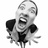

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

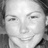

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')

## Split

In [ ]:
# base de dados de treinamento
gerador_train = ImageDataGenerator(rescale=1./255, #normalizacao
                                         rotation_range=7, #rotacao
                                         horizontal_flip=True, #rotacao horizontal
                                         zoom_range=0.2) #zoom

dataset_train = gerador_train.flow_from_directory('/content/fer2013/train', #criacao do dataset seguindo o modelo da rede neural original
                                                              target_size = (48, 48), #verificar o tamanho das imagens originais.
                                                              batch_size = 16,
                                                              class_mode = 'categorical', #mais de duas classes
                                                              shuffle = True)

Found 28709 images belonging to 7 classes.


In [ ]:
dataset_train.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
np.unique(dataset_train.classes, return_counts=True) #classes e quantidade de cada um

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

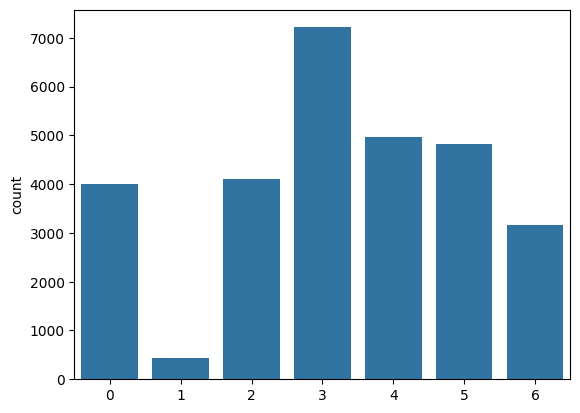

In [ ]:
sns.countplot(x = dataset_train.classes);

In [ ]:
# base de dados de test
gerador_test = ImageDataGenerator(rescale=1./255) #normalizacao

dataset_test = gerador_test.flow_from_directory('/content/fer2013/validation', #criacao do dataset seguindo o modelo da rede neural original
                                                              target_size = (48, 48), #verificar o tamanho das imagens originais.
                                                              batch_size = 1, #passar uma imagem  por  vez
                                                              class_mode = 'categorical', #mais de duas classes
                                                              shuffle = False)

Found 3589 images belonging to 7 classes.


## Contrucao e Treinamento.

In [ ]:
numero_detectores = 32 #quantidade de filtros da rede convolucional.
numero_calsses = 7 #as emocoes
largura, altura = 48,48
epocas = 3

In [ ]:
#arquiterura da rede
rede = Sequential()
rede.add(Conv2D(filters = numero_detectores, kernel_size=(3,3), activation='relu', padding='same', input_shape=(largura, altura, 3))) #primeira camada convolucional
#padding eh a forma como o filtro eh aplicado, nesse caso aproveitando todos os pixels das iamgens
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#segunda camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2)) #evita overfiting zerando 20% dos neuronios

rede.add(Conv2D(filters = 2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #terceira camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#quarta camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Conv2D(filters = 2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #quinta camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#sexta camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Conv2D(filters = 2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #setima camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#oitava camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Flatten())

rede.add(Dense(units=2*numero_detectores, activation = 'relu')) #primeira cadama oculta
rede.add(BatchNormalization())
rede.add(Dropout(0.2))

rede.add(Dense(units=2*numero_detectores, activation = 'relu')) #segunda cadama oculta
rede.add(BatchNormalization())
rede.add(Dropout(0.2))

rede.add(Dense(units=numero_calsses, activation = 'softmax')) #camada de saida
print(rede.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rede.fit(dataset_train, epochs=epocas)

Epoch 1/3
1795/1795 [==============================] - 81s 34ms/step - loss: 1.8518 - accuracy: 0.2678
Epoch 2/3
1795/1795 [==============================] - 56s 31ms/step - loss: 1.5569 - accuracy: 0.3930
Epoch 3/3
1795/1795 [==============================] - 57s 32ms/step - loss: 1.3979 - accuracy: 0.4655


## Salvar e carregar a RN

In [ ]:
#model_json = network.to_json()
#with open('network_emotions.json','w') as json_file:
  #json_file.write(model_json)

In [ ]:
#network_saved = save_model(network, '/content/weights_emotions.hdf5')

In [ ]:
#carregar modelo pronto
with open('/content/drive/MyDrive/Visão Computacional Guia Completo/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [ ]:
rede_loaded = tf.keras.models.model_from_json(json_saved_model) #modelo
rede_loaded.load_weights('/content/drive/MyDrive/Visão Computacional Guia Completo/Weights/weights_emotions.hdf5') #pesos
rede_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
rede_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Avaliação da rede neural

In [ ]:
# forma rapida de avaliar o modelo
rede_loaded.evaluate(dataset_test)

3589/3589 [==============================] - 28s 7ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [ ]:
previsoes = rede_loaded.predict(dataset_test)
previsoes
#cada uma das imagens eh retornada yum vetor de 7 posicoes

3589/3589 [==============================] - 23s 6ms/step


array([[9.13990259e-01, 5.24317101e-03, 2.00650208e-02, ...,
        7.55342515e-03, 3.91561240e-02, 1.23086749e-02],
       [8.34895313e-01, 1.31147943e-04, 1.60493657e-01, ...,
        8.83346482e-04, 3.42258206e-03, 1.44678467e-07],
       [9.68744576e-01, 7.42953096e-04, 1.70952734e-02, ...,
        1.25664158e-03, 7.57124368e-03, 4.92689491e-04],
       ...,
       [1.75535586e-03, 4.70192317e-05, 4.10514139e-02, ...,
        1.66567741e-03, 2.93833646e-03, 9.52457905e-01],
       [2.91052531e-03, 4.30332548e-05, 6.92667887e-02, ...,
        3.61312360e-01, 3.13797593e-03, 5.30261457e-01],
       [2.68193465e-02, 2.26625754e-03, 1.13005705e-01, ...,
        4.77516092e-03, 7.12134037e-03, 8.45583379e-01]], dtype=float32)

In [ ]:
previsoes = np.argmax(previsoes, axis=1)
previsoes

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
accuracy_score(dataset_test.classes, previsoes)

0.5778768459180831

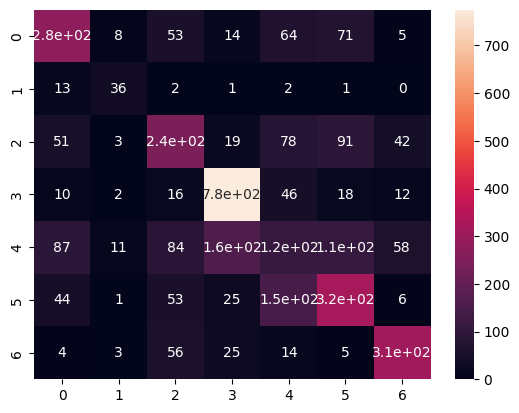

In [ ]:
cm = confusion_matrix(dataset_test.classes, previsoes)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(dataset_test.classes, previsoes))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



## Classificacao de uma imagem

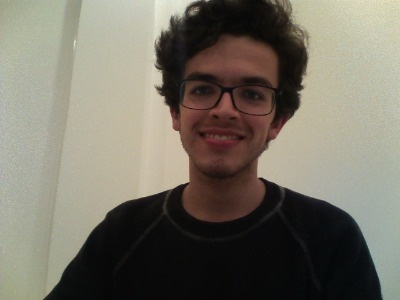

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Visão Computacional Guia Completo/Images/gabriel.png')
cv2_imshow(imagem)

In [ ]:
imagem.shape

(300, 400, 3)

In [ ]:
#eh preciso enviar apenas a face, nao a foto inteira.
#carregar um detector de faces
detector_face = cv2.CascadeClassifier('/content/drive/MyDrive/Visão Computacional Guia Completo/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
imagem_original = imagem.copy() #copia
deteccoes = detector_face.detectMultiScale(imagem_original) #detecoess encontradas

In [ ]:
deteccoes #bounding box de onde a face foi detectada

array([[162,  40, 128, 128]], dtype=int32)

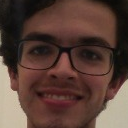

In [ ]:
#extrair o que ha dentro do bounding box
roi = imagem[40:40+128, 162:162+128] #region of interest
cv2_imshow(roi)

In [ ]:
roi.shape

(128, 128, 3)

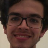

In [ ]:
#redimensionar a imagem
roi = cv2.resize(roi,(48,48)) #tamanho que a rede neural foi treinada
cv2_imshow(roi)

In [ ]:
roi.shape

(48, 48, 3)

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]], dtype=uint8)
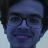

In [ ]:
roi

In [ ]:
# normalizacao entre 0 e 1
roi = roi/255

In [ ]:
#add uma dimensao a mais no incio que significa o batch, ou seja, a quantidade de imagem que sera enviada a rede, nesse caso, 1 apenas
roi = np.expand_dims(roi, axis=0)
roi.shape

(1, 48, 48, 3)

In [ ]:
probs = rede_loaded.predict(roi)
probs

1/1 [==============================] - 0s 460ms/step


array([[5.2841782e-04, 1.1444075e-06, 1.2489490e-03, 8.9390194e-01,
        1.0206461e-01, 2.1787002e-03, 7.6220604e-05]], dtype=float32)

In [ ]:
previsao = np.argmax(probs)
previsao #indice de maior valor encontrado
#3 = happy

3

## Classificação de múltiplas imagens

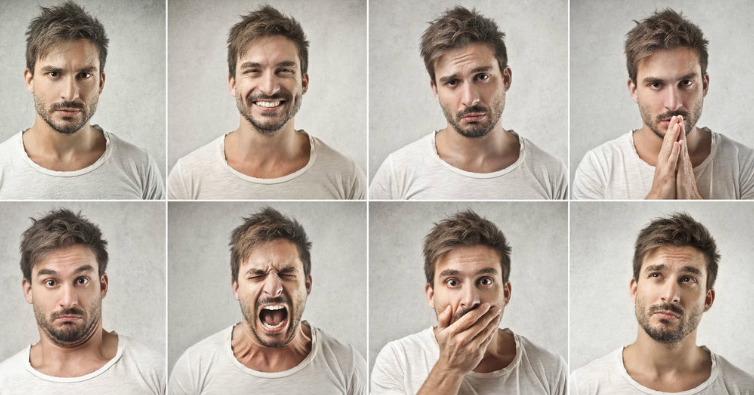

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Visão Computacional Guia Completo/Images/faces_emotions.png')
cv2_imshow(imagem)

In [ ]:
deteccoes = detector_face.detectMultiScale(imagem) #detector
deteccoes
# 8 bounding box

array([[224,  35,  90,  90],
       [ 23,  41,  92,  92],
       [625,  49,  91,  91],
       [420,  43,  97,  97],
       [229, 242,  85,  85],
       [420, 242,  97,  97],
       [627, 241,  91,  91],
       [ 18, 243,  98,  98]], dtype=int32)

In [ ]:
dataset_test.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [ ]:
dataset_test.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 31ms/step


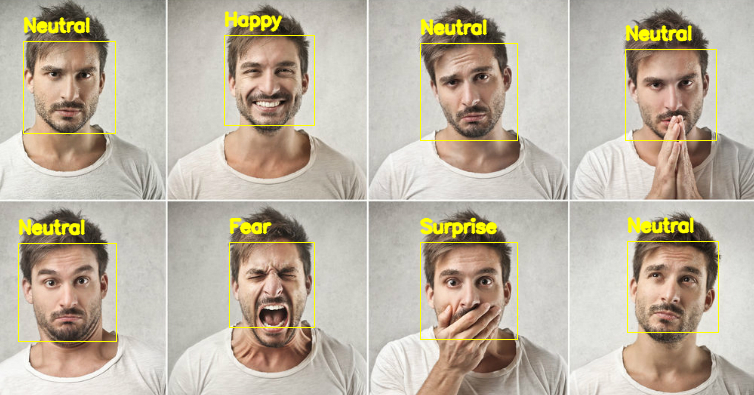

In [ ]:
for (x,y,w,h) in deteccoes:
  #print(x,y,w,h)
  cv2.rectangle(imagem, (x,y), (x+w, y+h), (0,255,255),1)
  roi = imagem[y:y+h, x:x+w] #extracao da parte interessada
  roi = cv2.resize(roi, (48,48))
  roi = roi/255
  roi = np.expand_dims(roi, axis=0)
  previsao = rede_loaded.predict(roi)
  cv2.putText(imagem, emotions[np.argmax(previsao)], (x,y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2, cv2.LINE_AA)

cv2_imshow(imagem)

## Classificação de emocoes em um video

In [ ]:
#leitura do primeiro frame do video
cap = cv2.VideoCapture('/content/drive/MyDrive/Visão Computacional Guia Completo/Videos/emotion_test01.mp4')
conectado, video = cap.read()
print(conectado, video.shape)
#true eh video lido com sucesso

True (360, 640, 3)


In [ ]:
save_path = ('/content/drive/MyDrive/Visão Computacional Guia Completo/Videos/emotion_test01_resulto.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID') #um codec para salvar videos
fps=24 #frames per second
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0])) #variavel que grava o video dps de ser processado

In [ ]:
while (cv2.waitKey(1)<0): #codigo para processar cada um dos frames do video
  conectado, frame = cap.read()
  if not conectado:
    break

  deteccoes = detector_face.detectMultiScale(frame, scaleFactor=1.2, minNeighbors = 5, minSize=(30,30))
  if len(deteccoes)>0: #se ha alguma face
    for (x,y,w,h) in deteccoes:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 2) #desenha o retangulo
      roi = frame[y:y + h, x:x + w] #encontra a face
      roi = cv2.resize(roi, (48,48)) #redimensiona para a rede
      roi = roi / 255 #normaliza
      roi = np.expand_dims(roi, axis = 0) #add uma dimensao
      previsao = rede_loaded.predict(roi) #faz a previsao

      if previsao is not None: #se for encontrada alguma coisa, escreve na iamgem
        resultado = np.argmax(previsao)
        cv2.putText(frame, emotions[resultado], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

  cv2_imshow(frame)
  output_video.write(frame)


print('fim')
output_video.release()#liberar a memoria
cv2.destroyAllWindows()